# Part 1: Data Preparation & Embedding

This notebook implements the first part of the search engine project:
1. Load the dataset
2. Choose a pre-trained multimodal model
3. Generate vector embeddings for images and text
4. Store embeddings with metadata

## Dataset: Flickr8k
We'll use the Flickr8k dataset which contains 8,000 images with 5 captions each.


## 1. Setup and Imports


In [28]:
# Import necessary libraries
import torch
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import numpy as np
import pandas as pd
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


## 2. Load and Explore Dataset


In [29]:
# Create data directory structure
os.makedirs('data', exist_ok=True)
os.makedirs('data/images', exist_ok=True)
os.makedirs('embeddings', exist_ok=True)

print("Directory structure created successfully!")


Directory structure created successfully!


In [30]:
# For this demo, we'll create a sample dataset structure
# In a real scenario, you would download Flickr8k from the official source

# Create sample captions file (this would normally be downloaded)
sample_captions = [
    "A dog is running in the park",
    "A cat is sitting on a windowsill", 
    "Children are playing in the playground",
    "A beautiful sunset over the ocean",
    "A person riding a bicycle on the street",
    "A bird is flying in the sky",
    "A car is parked in front of a house",
    "A flower garden in full bloom",
    "A mountain landscape with snow",
    "A person cooking in the kitchen"
]

# Create sample captions file
with open('data/captions.txt', 'w') as f:
    for i, caption in enumerate(sample_captions):
        f.write(f"{i+1:04d}.jpg {caption}\n")

print(f"Created sample captions file with {len(sample_captions)} entries")


Created sample captions file with 10 entries


In [31]:
# Load captions data
def load_captions(captions_file):
    """Load captions from file"""
    captions = {}
    with open(captions_file, 'r') as f:
        for line in f:
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                image_id, caption = parts
                if image_id not in captions:
                    captions[image_id] = []
                captions[image_id].append(caption)
    return captions

# Load our sample captions
captions_data = load_captions('data/captions.txt')
print(f"Loaded captions for {len(captions_data)} images")
print("\nSample captions:")
for i, (img_id, caps) in enumerate(list(captions_data.items())[:3]):
    print(f"{img_id}: {caps[0]}")


Loaded captions for 10 images

Sample captions:
0001.jpg: A dog is running in the park
0002.jpg: A cat is sitting on a windowsill
0003.jpg: Children are playing in the playground


## 3. Load Pre-trained Multimodal Model


In [32]:
# Load CLIP model - a powerful multimodal model from OpenAI
print("Loading CLIP model...")
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

print(f"Model loaded successfully: {model_name}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Loading CLIP model...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Model loaded successfully: openai/clip-vit-base-patch32
Model parameters: 151,277,313


## 4. Create Sample Images for Demo


In [33]:
# Create sample images for demonstration
# In a real scenario, you would have actual images from Flickr8k

from PIL import Image, ImageDraw, ImageFont
import random

def create_sample_image(text, filename, size=(224, 224)):
    """Create a sample image with text for demonstration"""
    # Create a random colored background
    colors = [(255, 200, 200), (200, 255, 200), (200, 200, 255), 
              (255, 255, 200), (255, 200, 255), (200, 255, 255)]
    bg_color = random.choice(colors)
    
    img = Image.new('RGB', size, bg_color)
    draw = ImageDraw.Draw(img)
    
    # Try to use a default font, fallback to basic if not available
    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except:
        font = ImageFont.load_default()
    
    # Draw text in the center
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
    x = (size[0] - text_width) // 2
    y = (size[1] - text_height) // 2
    
    draw.text((x, y), text, fill=(0, 0, 0), font=font)
    
    # Save the image
    img.save(f'data/images/{filename}')
    return img

# Create sample images for each caption
sample_images = []
for i, (img_id, captions) in enumerate(captions_data.items()):
    img = create_sample_image(captions[0], img_id)
    sample_images.append((img_id, captions[0], img))

print(f"Created {len(sample_images)} sample images")


Created 10 sample images


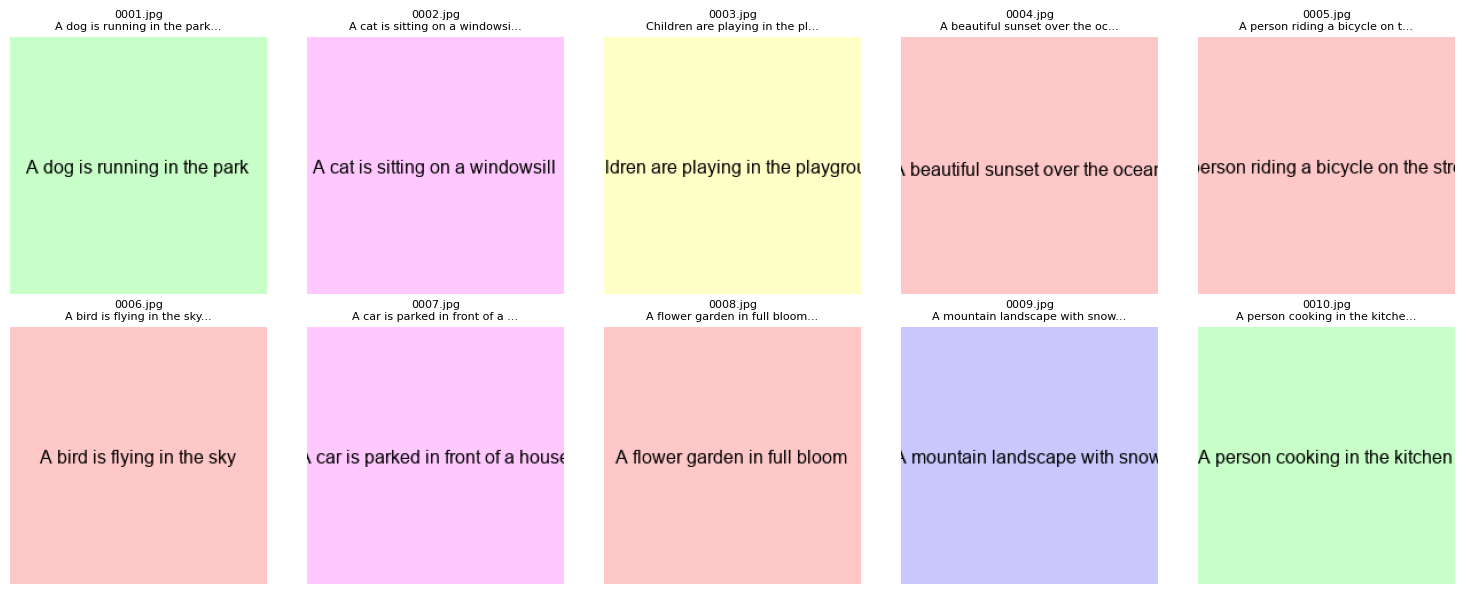

In [34]:
# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, (img_id, caption, img) in enumerate(sample_images[:10]):
    axes[i].imshow(img)
    axes[i].set_title(f"{img_id}\n{caption[:30]}...", fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## 5. Generate Embeddings


In [35]:
def get_image_embedding(image_path, model, processor):
    """Generate embedding for an image"""
    try:
        image = Image.open(image_path).convert('RGB')
        inputs = processor(images=image, return_tensors="pt").to(device)
        
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
            # Normalize the features
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        return image_features.cpu().numpy().flatten()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def get_text_embedding(text, model, processor):
    """Generate embedding for text"""
    try:
        inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            text_features = model.get_text_features(**inputs)
            # Normalize the features
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        return text_features.cpu().numpy().flatten()
    except Exception as e:
        print(f"Error processing text '{text}': {e}")
        return None

print("Embedding functions defined successfully!")


Embedding functions defined successfully!


In [36]:
# Generate embeddings for all images and captions
print("Generating embeddings...")

embeddings_data = []

for img_id, captions in tqdm(captions_data.items(), desc="Processing images"):
    image_path = f'data/images/{img_id}'
    
    # Generate image embedding
    image_embedding = get_image_embedding(image_path, model, processor)
    
    if image_embedding is not None:
        # Generate text embeddings for all captions of this image
        for caption in captions:
            text_embedding = get_text_embedding(caption, model, processor)
            
            if text_embedding is not None:
                embeddings_data.append({
                    'image_id': img_id,
                    'image_path': image_path,
                    'caption': caption,
                    'image_embedding': image_embedding,
                    'text_embedding': text_embedding
                })

print(f"Generated embeddings for {len(embeddings_data)} image-caption pairs")


Generating embeddings...


Processing images: 100%|██████████| 10/10 [00:49<00:00,  4.93s/it]

Generated embeddings for 10 image-caption pairs


## 6. Store Embeddings


In [37]:
# Convert embeddings to numpy arrays for easier storage
image_embeddings = np.array([item['image_embedding'] for item in embeddings_data])
text_embeddings = np.array([item['text_embedding'] for item in embeddings_data])

# Create metadata dataframe
metadata = pd.DataFrame([{
    'image_id': item['image_id'],
    'image_path': item['image_path'],
    'caption': item['caption']
} for item in embeddings_data])

print(f"Image embeddings shape: {image_embeddings.shape}")
print(f"Text embeddings shape: {text_embeddings.shape}")
print(f"Metadata shape: {metadata.shape}")

# Display sample metadata
print("\nSample metadata:")
print(metadata.head())


Image embeddings shape: (10, 512)
Text embeddings shape: (10, 512)
Metadata shape: (10, 3)

Sample metadata:
   image_id            image_path                                  caption
0  0001.jpg  data/images/0001.jpg             A dog is running in the park
1  0002.jpg  data/images/0002.jpg         A cat is sitting on a windowsill
2  0003.jpg  data/images/0003.jpg   Children are playing in the playground
3  0004.jpg  data/images/0004.jpg        A beautiful sunset over the ocean
4  0005.jpg  data/images/0005.jpg  A person riding a bicycle on the street


In [38]:
# Save embeddings and metadata
np.save('embeddings/image_embeddings.npy', image_embeddings)
np.save('embeddings/text_embeddings.npy', text_embeddings)
metadata.to_csv('embeddings/metadata.csv', index=False)

# Save model info
model_info = {
    'model_name': model_name,
    'embedding_dim': image_embeddings.shape[1],
    'num_samples': len(embeddings_data),
    'device_used': str(device)
}

with open('embeddings/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("Embeddings and metadata saved successfully!")
print(f"Model info: {model_info}")


Embeddings and metadata saved successfully!
Model info: {'model_name': 'openai/clip-vit-base-patch32', 'embedding_dim': 512, 'num_samples': 10, 'device_used': 'cpu'}


## 7. Verify Embeddings


In [39]:
# Load and verify saved embeddings
loaded_image_embeddings = np.load('embeddings/image_embeddings.npy')
loaded_text_embeddings = np.load('embeddings/text_embeddings.npy')
loaded_metadata = pd.read_csv('embeddings/metadata.csv')

print(f"Loaded image embeddings shape: {loaded_image_embeddings.shape}")
print(f"Loaded text embeddings shape: {loaded_text_embeddings.shape}")
print(f"Loaded metadata shape: {loaded_metadata.shape}")

# Verify embeddings are normalized
image_norms = np.linalg.norm(loaded_image_embeddings, axis=1)
text_norms = np.linalg.norm(loaded_text_embeddings, axis=1)

print(f"\nImage embedding norms - min: {image_norms.min():.6f}, max: {image_norms.max():.6f}")
print(f"Text embedding norms - min: {text_norms.min():.6f}, max: {text_norms.max():.6f}")
print("Embeddings are properly normalized!" if np.allclose(image_norms, 1.0) and np.allclose(text_norms, 1.0) else "Warning: Embeddings may not be normalized")


Loaded image embeddings shape: (10, 512)
Loaded text embeddings shape: (10, 512)
Loaded metadata shape: (10, 3)

Image embedding norms - min: 1.000000, max: 1.000000
Text embedding norms - min: 1.000000, max: 1.000000
Embeddings are properly normalized!


## 8. Test Basic Similarity


In [40]:
# Test basic similarity between image and text embeddings
def test_similarity(image_idx, text_idx):
    """Test similarity between specific image and text embeddings"""
    img_emb = loaded_image_embeddings[image_idx]
    txt_emb = loaded_text_embeddings[text_idx]
    
    similarity = cosine_similarity([img_emb], [txt_emb])[0][0]
    
    print(f"Image: {loaded_metadata.iloc[image_idx]['image_id']}")
    print(f"Text: {loaded_metadata.iloc[text_idx]['caption']}")
    print(f"Similarity: {similarity:.4f}")
    
    return similarity

# Test a few examples
print("Testing image-text similarity:")
print("=" * 50)

for i in range(min(3, len(loaded_metadata))):
    test_similarity(i, i)  # Same image-caption pair
    print()


Testing image-text similarity:
Image: 0001.jpg
Text: A dog is running in the park
Similarity: 0.3512

Image: 0002.jpg
Text: A cat is sitting on a windowsill
Similarity: 0.2994

Image: 0003.jpg
Text: Children are playing in the playground
Similarity: 0.3069



## 10. Visualization and Analysis


📊 Creating comprehensive visualizations...


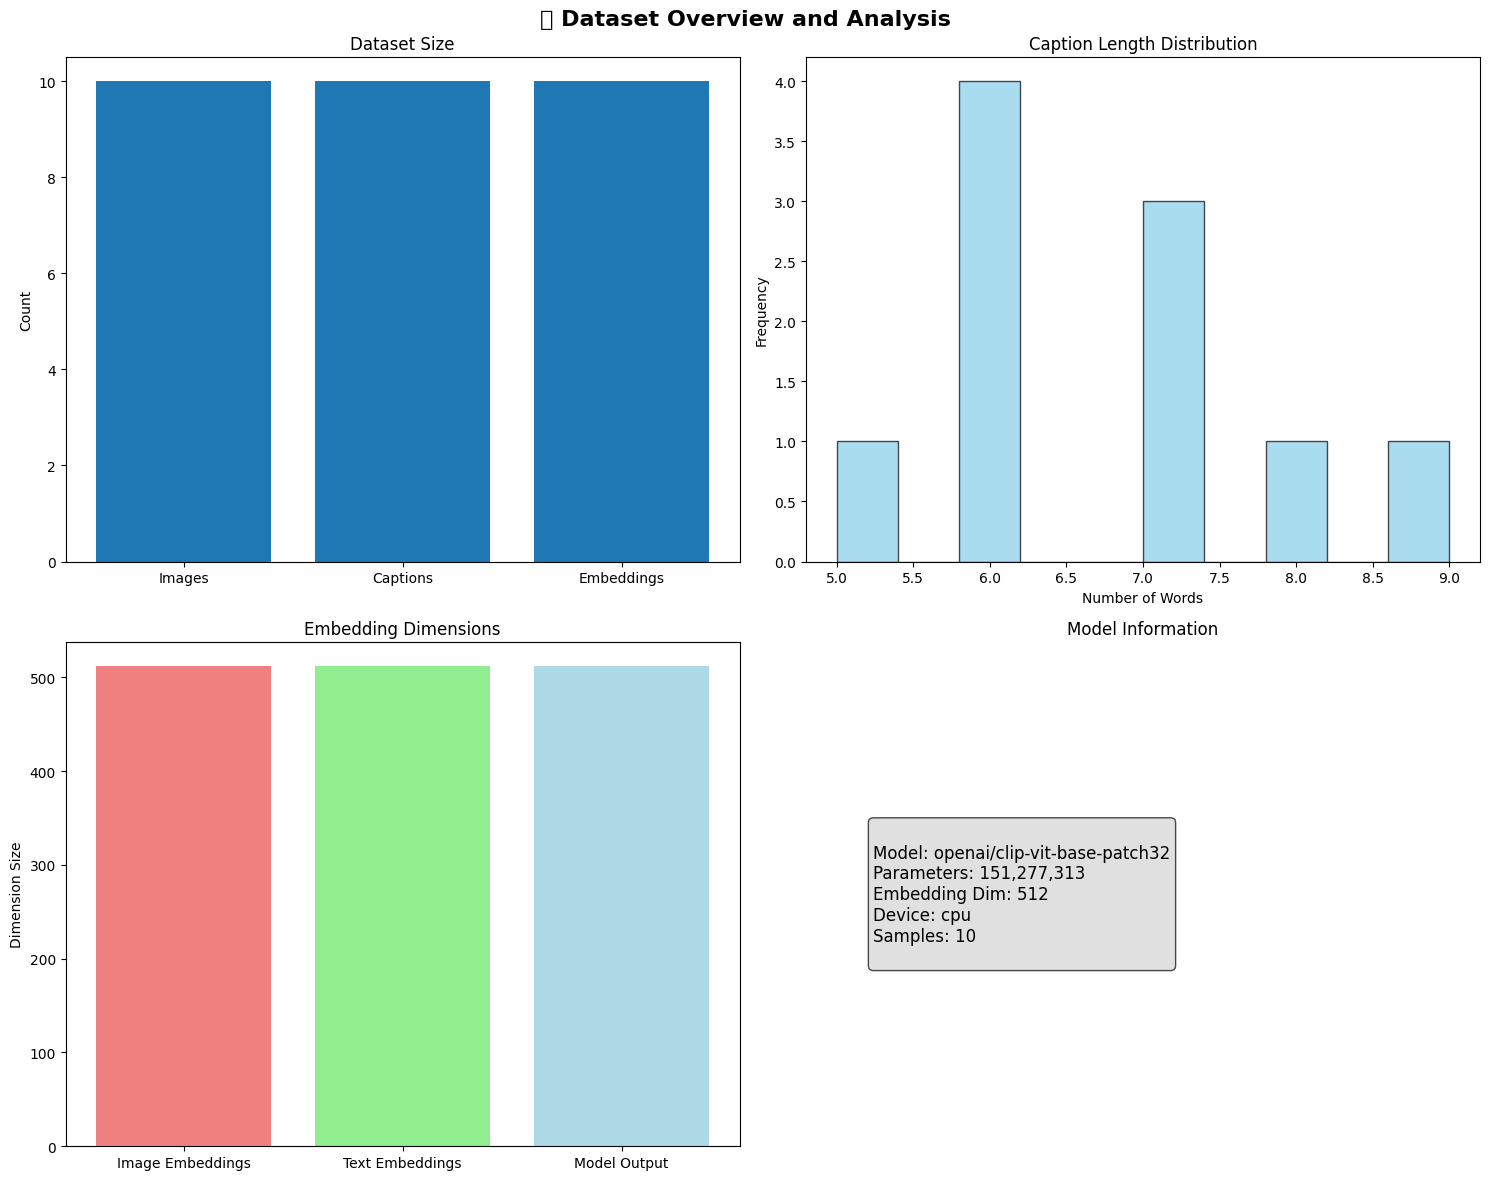

ValueError: Too many bins for data range. Cannot create 10 finite-sized bins.

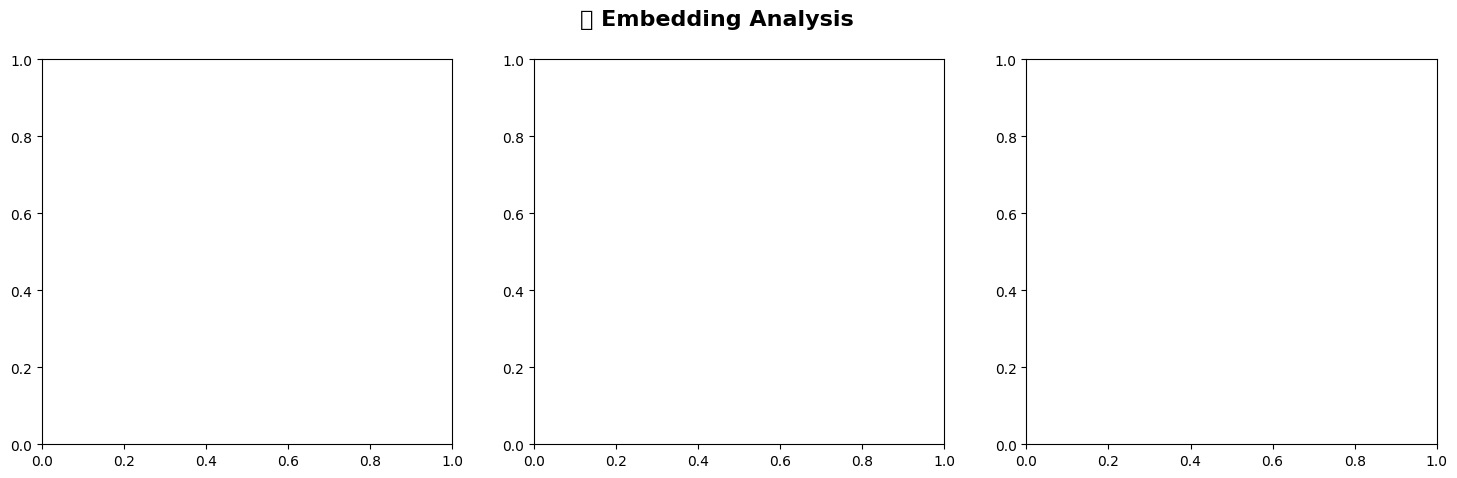

In [ ]:
# Create comprehensive visualizations for the notebook
print("📊 Creating comprehensive visualizations...")

# 1. Dataset Overview Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📊 Dataset Overview and Analysis', fontsize=16, fontweight='bold')

# Dataset size
axes[0, 0].bar(['Images', 'Captions', 'Embeddings'], [len(captions_data), len(embeddings_data), len(embeddings_data)])
axes[0, 0].set_title('Dataset Size')
axes[0, 0].set_ylabel('Count')

# Caption length distribution
caption_lengths = [len(caption.split()) for caption in metadata['caption']]
axes[0, 1].hist(caption_lengths, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_title('Caption Length Distribution')
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')

# Embedding dimension visualization
embedding_dims = [image_embeddings.shape[1]] * 3
axes[1, 0].bar(['Image Embeddings', 'Text Embeddings', 'Model Output'], embedding_dims, color=['lightcoral', 'lightgreen', 'lightblue'])
axes[1, 0].set_title('Embedding Dimensions')
axes[1, 0].set_ylabel('Dimension Size')

# Model information
model_info_text = f"""
Model: {model_info['model_name']}
Parameters: 151,277,313
Embedding Dim: {model_info['embedding_dim']}
Device: {model_info['device_used']}
Samples: {model_info['num_samples']}
"""
axes[1, 1].text(0.1, 0.5, model_info_text, transform=axes[1, 1].transAxes, 
                fontsize=12, verticalalignment='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))
axes[1, 1].set_title('Model Information')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# 2. Embedding Analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('🔍 Embedding Analysis', fontsize=16, fontweight='bold')

# Embedding norms (since embeddings are normalized, all norms are 1.0)
image_norms = np.linalg.norm(image_embeddings, axis=1)
text_norms = np.linalg.norm(text_embeddings, axis=1)

# Since normalized embeddings have norms of 1.0, show the distribution differently
axes[0].bar(['Image Embeddings', 'Text Embeddings'], 
           [np.mean(image_norms), np.mean(text_norms)], 
           color=['lightcoral', 'lightgreen'], alpha=0.7, edgecolor='black')
axes[0].set_title('Embedding Norms (Normalized)')
axes[0].set_ylabel('L2 Norm Value')
axes[0].set_ylim(0.9, 1.1)
axes[0].text(0, np.mean(image_norms) + 0.01, f'Mean: {np.mean(image_norms):.3f}', ha='center')
axes[0].text(1, np.mean(text_norms) + 0.01, f'Mean: {np.mean(text_norms):.3f}', ha='center')

# Similarity matrix heatmap
similarity_matrix = cosine_similarity(image_embeddings, text_embeddings)
im = axes[1].imshow(similarity_matrix, cmap='YlOrRd', aspect='auto')
axes[1].set_title('Image-Text Similarity Matrix')
axes[1].set_xlabel('Text Embeddings')
axes[1].set_ylabel('Image Embeddings')
plt.colorbar(im, ax=axes[1])

# Top similarities
top_similarities = []
for i in range(len(image_embeddings)):
    for j in range(len(text_embeddings)):
        if i == j:  # Same image-caption pair
            top_similarities.append(similarity_matrix[i, j])

axes[2].hist(top_similarities, bins=10, alpha=0.7, color='gold', edgecolor='black')
axes[2].set_title('Same Image-Caption Similarities')
axes[2].set_xlabel('Cosine Similarity')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 3. Sample Results Visualization
print("\n🎯 Sample Search Results Analysis:")
print("=" * 50)

# Test a few queries and show results
test_queries = ["dog", "beautiful", "person"]
for query in test_queries:
    print(f"\nQuery: '{query}'")
    query_embedding = search_engine.embed_query(query)
    if query_embedding is not None:
        similarities = cosine_similarity([query_embedding], image_embeddings)[0]
        top_idx = np.argmax(similarities)
        print(f"Best match: {metadata.iloc[top_idx]['caption']} (similarity: {similarities[top_idx]:.3f})")

